# Prototype Hyperspectral Workflow

### Workflow
+ Helpers
+ Prepare Metadata
+ Colormap Lookup/Legend
+ Read Sample Map/Mask Images


Dependency: Minalyze environment



In [1]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from PIL import Image 

## Helpers

Prototype helper functions, which will be integrated into the framework.

#### Metadata

In [2]:
def datastore_metadata( path_to_images ):
    """Prepare metadata on datastore"""
    image_map_files = []
    for file in os.listdir( path_to_images ):
        if file.endswith( ".png" ):
            image_map_files.append(file)
    df = pd.DataFrame(image_map_files, columns=["filename"])

    identifiers = parse_identifier( df )

    depths = parse_depths( df )

    image_metadata = pd.concat([df, identifiers, depths], axis=1)

    image_metadata = image_metadata\
        .sort_values(by="box-id")\
        .reset_index( drop=True )
    return image_metadata


def parse_identifier(df):
    """Parse identifier string in mineralmap and mask filenames"""
    identifiers = df["filename"]\
        .str.extract("CMM-(.*)@",expand=False)\
        .str.split("_", expand=True)\
        .astype("int")
    identifiers.columns = ["core-id", "box-id"] 
    return identifiers


def parse_depths(df):
    """Parse depth string in mineralmap and mask filenames"""
    depths = df["filename"]\
        .str.extract("@(.*).png",expand=False)\
        .str.split("_", expand=True)\
        .astype("float")
    depths.columns = ["depth-start", "depth-end"] 
    return depths 

#### Datastore I/O

In [3]:
def read_datastore( path_to_images, mode="sample"):
    """Read images into an ndarray array"""

    image_metadata = datastore_metadata( path_to_images )

    if mode == "sample":
        n = 5
    elif mode == "all":
        n = image_metadata.shape[0]
    else:
        raise Exception("Unknown mode selection. Select sample or all.")

    images = [None] * n
    for i in range(0,n):
        images[i] = np.array( 
            Image.open( os.path.join(path_to_images,  image_metadata["filename"][i]) ) 
            )  
    return images


#### Plotting

In [1]:
def plot_core_box( images ):
    """Preview image array"""
    n = len(images)

    # truncate 
    if n>5:
        n=5
        images = images[:5]

    fig, ax  = plt.subplots(1,n, figsize=(18,12))
    for item,image in zip(ax,images):
        item.imshow(image, interpolation="none")


def plot_core_column( core_column ):
    """Plot core box column"""
    fig, ax  = plt.subplots(1,1, figsize=(18,12))
    ax.imshow(core_column, interpolation="none", aspect=.2)
    ax.set_ylabel("pixel depth")


def plot_box_curves( mineral_matrix, mineral_keys ):
    """Plot mineral curves"""
    n_element = get_mineral_count( mineral_matrix )
    n_pixel   = get_pixel_depth( mineral_matrix )
    pixel_depth = np.arange(0,n_pixel)

    fig, ax = plt.subplots(1,n_element, figsize=(18,12), sharey=True)
    for i in range( len(ax) ):
        ax[i].plot(mineral_matrix[:,i], pixel_depth)
        ax[i].set_title(mineral_keys[i])
    ax[0].invert_yaxis()
    ax[0].set_ylabel( "pixel depth" )
    return ax


def plot_box_composition( mineral_prc_matrix, mineral_keys, mineral_colormap ):
    """Plot core box mineral composition"""

    mineral_cumulative = calc_cumulative_prc( mineral_prc_matrix )

    n_pixel = get_pixel_depth(mineral_prc_matrix)
    pixel_depth = np.arange(0,n_pixel)

    mineral_plot_matrix, mineral_colors, mineral_legend = transpose_and_invert( mineral_cumulative, 
        mineral_keys, mineral_colormap)

    fig, ax = plt.subplots(1,1, figsize=(4,12))
    box_fill( ax, pixel_depth, mineral_plot_matrix, mineral_colors)
    ax.invert_yaxis()
    ax.legend(mineral_legend,loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("[%]")
    ax.set_ylabel("pixel depth");


def plot_box_image_and_composition( core_column, mineral_prc_matrix, mineral_keys, mineral_colormap ):
    """Plot core box column and mineral composition"""

    mineral_cumulative = calc_cumulative_prc( mineral_prc_matrix )
    n_pixel = get_pixel_depth(mineral_prc_matrix)
    pixel_depth = np.arange(0,n_pixel)

    fig, ax  = plt.subplots(1, 2, figsize=(8,12), sharey=True)
    # plot the core column 
    ax[0].imshow(core_column, aspect=.2)

    #plot the box mineral composition in the second column
    mineral_plot_matrix, mineral_colors, mineral_legend = transpose_and_invert( mineral_cumulative, 
        mineral_keys, mineral_colormap)
    box_fill( ax[1], pixel_depth, mineral_plot_matrix, mineral_colors)

    ax[0].axis('off')
    ax[1].axis('off')
    ax[1].legend(mineral_legend,loc='center left', bbox_to_anchor=(1, 0.5))
    fig.subplots_adjust(wspace=0, hspace=0)
    return fig
    

#### Algorithm Development 

In [5]:
def mask_image( image, preview=True ):
    """Mask background pixels of minalyze map image"""
    mask = np.all(image == (0,0,0), axis=-1)
    image_masked = np.copy( image )
    image_masked[mask,:]= [255, 255, 255]

    if preview:
        fig, ax  = plt.subplots(1,1, figsize=(8,8))
        ax.imshow(image_masked, interpolation="none");
    return image_masked 


def identify_box( mask ):
    """Identify core box columns as mask"""
    bg = np.sum(mask==False, axis=0) == mask.shape[0]
    core_column = label( np.invert(bg) )
    return core_column


def segment_box( box, compartment_mask ):
    """Segment core box""" 
    n_column = np.max( np.unique(compartment_mask) )
    n = n_column+1

    array = [None] * n_column
    for i in range(1,n):
            array[i-1] = box[:, compartment_mask==i]
    return array 


def get_compartment_count( compartment_mask ):
    """Number of core columns/compartments"""
    n_compartment = np.max( np.unique( compartment_mask ) )
    return n_compartment


def get_core_compartments( image, mask, astype="image" ):
    """Segment core box into array of core columns"""
    core_compartments = identify_box( mask )
    
    if astype == "image":
        array = segment_box( image, core_compartments )
    elif astype == "mask":
        array = segment_box( mask, core_compartments )
    else:
        array = None
    return array 


def compartment_to_column( compartments ):
    """Convert core box compartments to column"""

    nchannel = compartments[0].shape[2]
    nrow     = compartments[0].shape[0]  
    ncol     = np.array( [item.shape[1] for item in compartments] )

    to_pad = max(ncol) - ncol

    padded=[]
    for (item, value) in zip(compartments,to_pad):
        extra_left, extra_right=[
            np.floor(value/2).astype("int"),
            np.ceil(value/2).astype("int")
            ]
        array = np.pad(item,((0,0),(extra_left,extra_right),(0,0)), 
            mode="constant", constant_values=255)
        padded.append(array)
    column = np.concatenate(padded, axis=0)
    return column

In [6]:
def get_core_pixel_counts( mask, core_compartment ):
    """Get core pixel count per row per compartment"""

    compartments = segment_box( mask, core_compartment )

    n_row = compartments[0].shape[0] 
    n_column = len(compartments)
    n = n_column

    column_pixel_counts = np.zeros( (n_row,n_column ) )
    for j in range(0,n):
        column_pixel_counts[:,j] = np.sum( compartments[j], axis=1 )
    column_pixel_counts[column_pixel_counts==0] = np.nan
    return column_pixel_counts


def get_mineral_pixel_counts( image, mask, mineral_dictionary ):
    """Get all mineral pixel counts per row per compartment"""

    # segment core box mask into columns / compartments 
    core_compartments = identify_box( mask )

    # core pixel counts by row/compartment
    column_pixel_counts = get_core_pixel_counts( mask, core_compartments )

    # define tensor dimensions 
    n_row     = mask.shape[0] 
    n_column  = get_compartment_count( core_compartments )
    n_mineral = len( mineral_dictionary )
    n = n_column

    mineral_pixel_counts = np.zeros( (n_row, n_column, n_mineral) )

    #loop over minerals and core compartments 
    for k, (key,value) in enumerate( mineral_dictionary.items() ):
        mineral = np.all(image == value, axis=-1)
        compartments = segment_box( mineral, core_compartments )
        for j in range(0, n):
            mineral_pixel_counts[:,j,k] = np.sum(compartments[j],axis=1)
    return mineral_pixel_counts


def get_mineral_pixel_prc( mineral_pixel_counts, core_pixel_counts ):
    """Get all mineral pixel percentage per row per compartment"""
    mineral_pixel_prc = mineral_pixel_counts / core_pixel_counts[:,:, np.newaxis]
    return mineral_pixel_prc


def tensor_to_matrix(mineral_tensor):
    """Convert mineral tensor to a mineral matrix"""
    mineral_matrix = np.concatenate( mineral_tensor.transpose(1,0,2), axis=0)
    return mineral_matrix   


def get_mineral_count(mineral_matrix):
    """Get number of minerals in core"""
    n_element = mineral_matrix.shape[1]
    return n_element


def get_pixel_depth(mineral_matrix):
    """Core box column pixel depth"""
    n_pixel = mineral_matrix.shape[0]
    return n_pixel


def discretize_box_column( image, mineral_matrix ):
    """Discretize core box pixel column depth by compartment"""
    core_compartments = identify_box( image )
    n_image_pixel  = image.shape[0]
    n_column_pixel = get_pixel_depth( mineral_matrix )
    column_pixel_depth = np.arange(0, n_column_pixel)

    bins = np.append(np.array(0), np.cumsum(np.ones(n_compartments)*n_image_pixel))
    core_column_index = np.digitize(column_pixel_depth, bins)
    return core_column_index


def calc_cumulative_prc( mineral_prc_matrix ):
    """Calculate mineral cumulative percent per row. 
       Zero values assigned NaN. 
    """
    mineral_cumulprc = np.cumsum(mineral_prc_matrix, axis=1)
    mineral_cumulprc[mineral_cumulprc==0] = np.nan
    return mineral_cumulprc


def transpose_and_invert(mineral_matrix, mineral_keys, mineral_colormap):
   """Transpose and invert matrix for composition plot"""
   mineral_plot_matrix = np.flipud( mineral_matrix.transpose() )
   mineral_colors = mineral_colormap[::-1]
   mineral_legend = mineral_keys[::-1]
   return mineral_plot_matrix, mineral_colors, mineral_legend


def box_fill( ax, pixel_depth, mineral_matrix, mineral_colors):
   """Create filled plot""" 
   for i,mineral in enumerate(mineral_matrix):
       p = ax.fill_betweenx(pixel_depth, mineral, color=mineral_colors[i])


## Prepare Metadata

Organize and prepare mineral-map and core-mask metadata. These metadata contain an inventory of images and associated attributes such as the box-id, start-depth, and end-depth.

Mineral map preparation

In [7]:
path_to_data    = "../../data/cmm-111C-coremask-mineralmap/"

In [8]:
path_to_mineral = os.path.join(path_to_data, "borehole-mineral-map")

mineralmap_metadata = datastore_metadata( path_to_mineral )
mineralmap_metadata.head()

,filename,core-id,box-id,depth-start,depth-end
0,Borehole_Mineral_MAP__VN-SWIR__CMM-111_1@0_10.png,111,1,0.0,10.0
1,Borehole_Mineral_MAP__VN-SWIR__CMM-111_2@10_19...,111,2,10.0,19.5
2,Borehole_Mineral_MAP__VN-SWIR__CMM-111_3@19.5_...,111,3,19.5,28.5
3,Borehole_Mineral_MAP__VN-SWIR__CMM-111_4@28.5_...,111,4,28.5,37.5
4,Borehole_Mineral_MAP__VN-SWIR__CMM-111_5@37.5_...,111,5,37.5,47.5


In [9]:
mineralmap_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   filename     238 non-null    object 
 1   core-id      238 non-null    int64  
 2   box-id       238 non-null    int64  
 3   depth-start  238 non-null    float64
 4   depth-end    238 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 9.4+ KB


Core mask metadata preparation

In [10]:
path_to_mask = os.path.join(path_to_data, "core-mask")

mask_metadata = datastore_metadata( path_to_mask )
mask_metadata.head()

,filename,core-id,box-id,depth-start,depth-end
0,Core_Mask__VN-SWIR__CMM-111_1@0_10.png,111,1,0.0,10.0
1,Core_Mask__VN-SWIR__CMM-111_2@10_19.5.png,111,2,10.0,19.5
2,Core_Mask__VN-SWIR__CMM-111_3@19.5_28.5.png,111,3,19.5,28.5
3,Core_Mask__VN-SWIR__CMM-111_4@28.5_37.5.png,111,4,28.5,37.5
4,Core_Mask__VN-SWIR__CMM-111_5@37.5_47.5.png,111,5,37.5,47.5


In [11]:
mask_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   filename     238 non-null    object 
 1   core-id      238 non-null    int64  
 2   box-id       238 non-null    int64  
 3   depth-start  238 non-null    float64
 4   depth-end    238 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 9.4+ KB


## Colormap Lookup/Legend 

Read the legend file and extract the colormap corresponding to each mineral in the data.


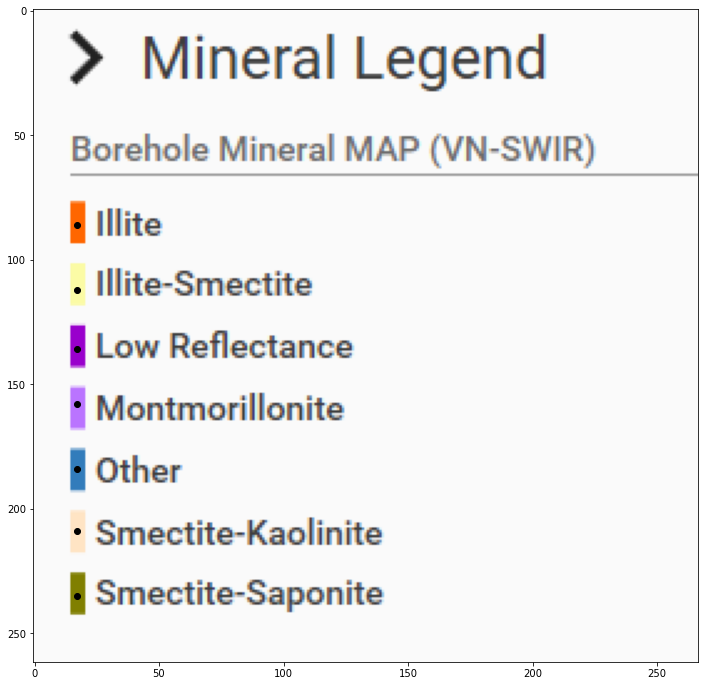

In [12]:
legend = np.array( 
    Image.open( os.path.join(path_to_data, "mineral-legend.png") ) 
    )

fig, ax  = plt.subplots(1,1, figsize=(18,12))
ax.imshow(legend)

points_to_sample =np.array([
    [17,86],
    [17, 112],
    [17,136],
    [17,158],
    [17,184],
    [17,209],
    [17,235],
    ])
ax.scatter(points_to_sample[:,0], points_to_sample[:,1], 
    marker="o", 
    color="black");

Create dictionary of mineral keys and colormap values.

In [13]:
mineral_keys = [
    "illite",
    "illite-smectite",
    "low-reflectance",
    "montmorillonite",
    "other",
    "smectite-kaolinite",
    "smectite-saponite",
]

pixel_values = []
pixel_values_scaled = [] 
for row in points_to_sample:
    value = legend[row[1],row[0]][:3]
    pixel_values.append( tuple(value) )
    pixel_values_scaled.append( tuple(value/255) )
pixel_values

mineral_categories = dict( zip(mineral_keys, pixel_values) )
n_mineral_categories = len(mineral_categories)
mineral_categories

{'illite': (255, 102, 0),
 'illite-smectite': (251, 251, 165),
 'low-reflectance': (153, 0, 204),
 'montmorillonite': (186, 116, 255),
 'other': (50, 124, 187),
 'smectite-kaolinite': (255, 228, 196),
 'smectite-saponite': (128, 127, 0)}

## Read Sample Map/Mask Images

In [14]:
images = read_datastore( path_to_mineral, mode="sample" )
len(images)

5

Image pixel may be different for each image.

In [15]:
for image in images:
    print(image.shape)

(517, 323, 3)
(527, 323, 3)
(528, 323, 3)
(528, 317, 3)
(536, 327, 3)


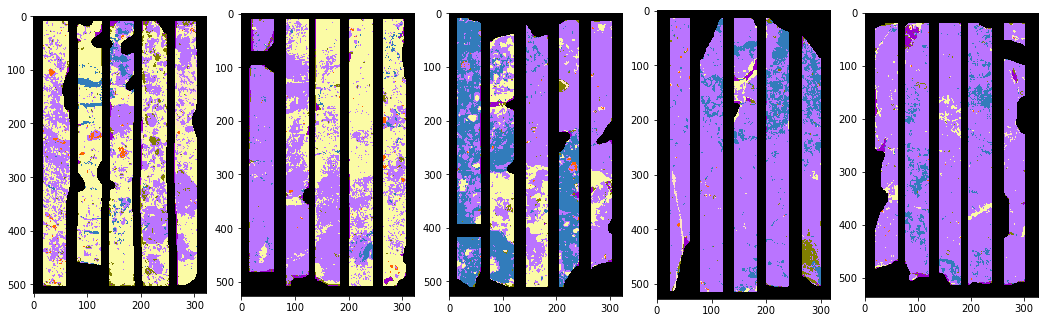

In [16]:
plot_core_box( images )

Read core mask images

In [17]:
cmasks = read_datastore( path_to_mask, mode="sample" )
len(cmasks)

5

In [18]:
for cmask in cmasks:
    print(cmask.shape)

(517, 323)
(527, 323)
(528, 323)
(528, 317)
(536, 327)


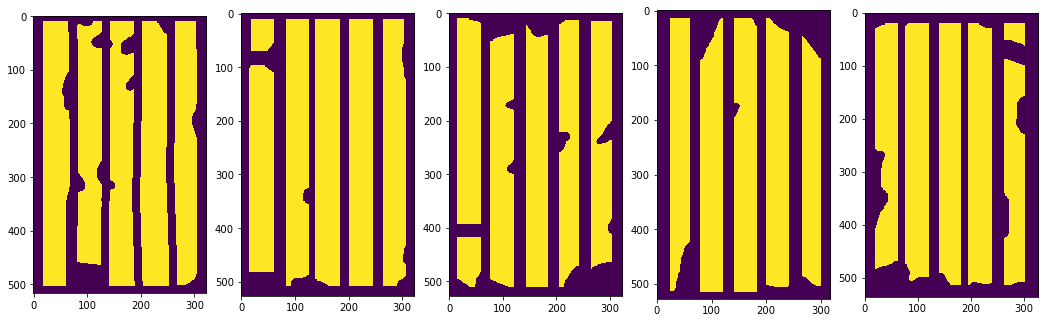

In [19]:
plot_core_box( cmasks )

## Algorithm Development

Prototype on single image and mask.

In [20]:
iD = 1
proto = images[1]
proto_cmask = cmasks[1]

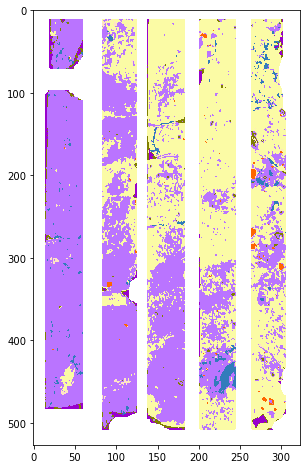

In [21]:
proto_masked = mask_image( proto )

Identify the core box columns.

In [22]:
core_compartments = identify_box( proto_cmask )

In [23]:
n_compartments = get_compartment_count( core_compartments )

Text(0, 0.5, 'core compartent')

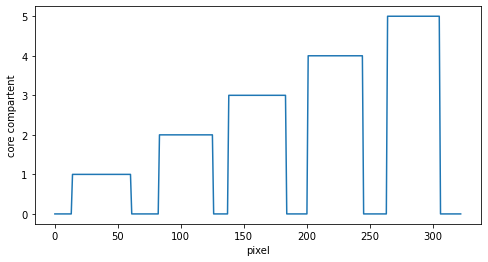

In [24]:
fig, ax  = plt.subplots(1,1, figsize=(8,4))
ax.plot(core_compartments)
ax.set_xlabel("pixel")
ax.set_ylabel("core compartent")

Segment the image into core columns / compartments

In [25]:
compartments = get_core_compartments(proto_masked, proto_cmask)

In [26]:
mask_compartments = get_core_compartments(proto_masked, proto_cmask, astype="mask")

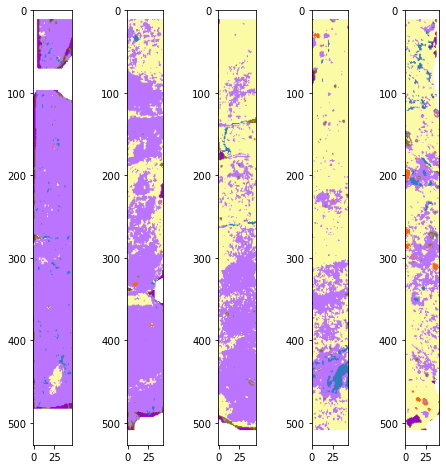

In [27]:
fig, ax  = plt.subplots(1,n_compartments, figsize=(8,8))
ax = ax.flatten()

for i,item in enumerate(compartments):
    ax[i].imshow(item)

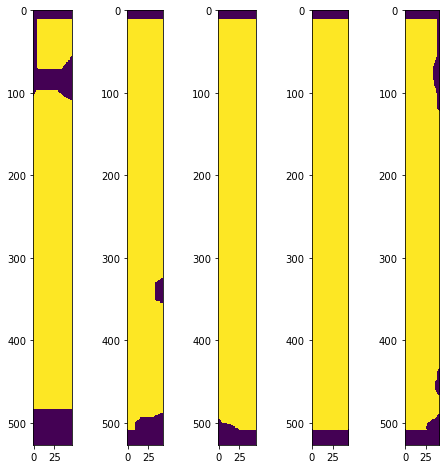

In [28]:
fig, ax  = plt.subplots(1,n_compartments, figsize=(8,8))
ax = ax.flatten()

for i,item in enumerate(mask_compartments):
    ax[i].imshow(item, interpolation="none")

Get core pixels counts per compartment per row. 

In [29]:
core_pixel_counts = get_core_pixel_counts( proto_cmask, core_compartments )

Text(0, 0.5, 'pixel depth')

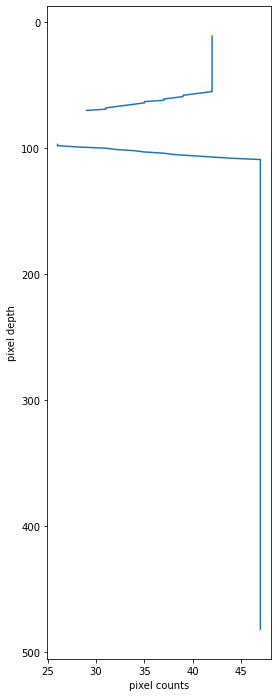

In [30]:
fig, ax = plt.subplots(1,1, figsize=(4,12))
ax.plot(core_pixel_counts[:,0],np.arange(0,proto_cmask.shape[0]) )
ax.invert_yaxis()
ax.set_xlabel("pixel counts")
ax.set_ylabel("pixel depth")

In [31]:
mineral_pixel_counts = get_mineral_pixel_counts( proto, proto_cmask, mineral_categories)
mineral_pixel_prc = get_mineral_pixel_prc( mineral_pixel_counts, core_pixel_counts )

Spot check mineral counts and percentage

Text(0.5, 0, '[%]')

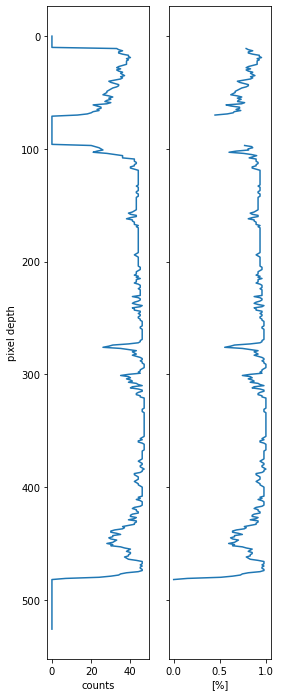

In [32]:
#Montmorillonite 
iD = 3
fig, ax = plt.subplots(1,2, figsize=(4,12), sharey=True)
ax[0].plot(mineral_pixel_counts[:,0,iD],np.arange(0,proto_cmask.shape[0]) )
ax[1].plot(mineral_pixel_prc[:,0,iD],np.arange(0,proto_cmask.shape[0]) )

ax[0].invert_yaxis()
ax[0].set_ylabel("pixel depth")
ax[0].set_xlabel("counts")
ax[1].set_xlabel("[%]")

In [34]:
mineral_pixel_prc_curves = tensor_to_matrix( mineral_pixel_prc )
mineral_pixel_counts_curves = tensor_to_matrix( mineral_pixel_counts )

In [35]:
mineral_pixel_prc_curves.shape

(2635, 7)

In [36]:
mineral_pixel_counts_curves.shape

(2635, 7)

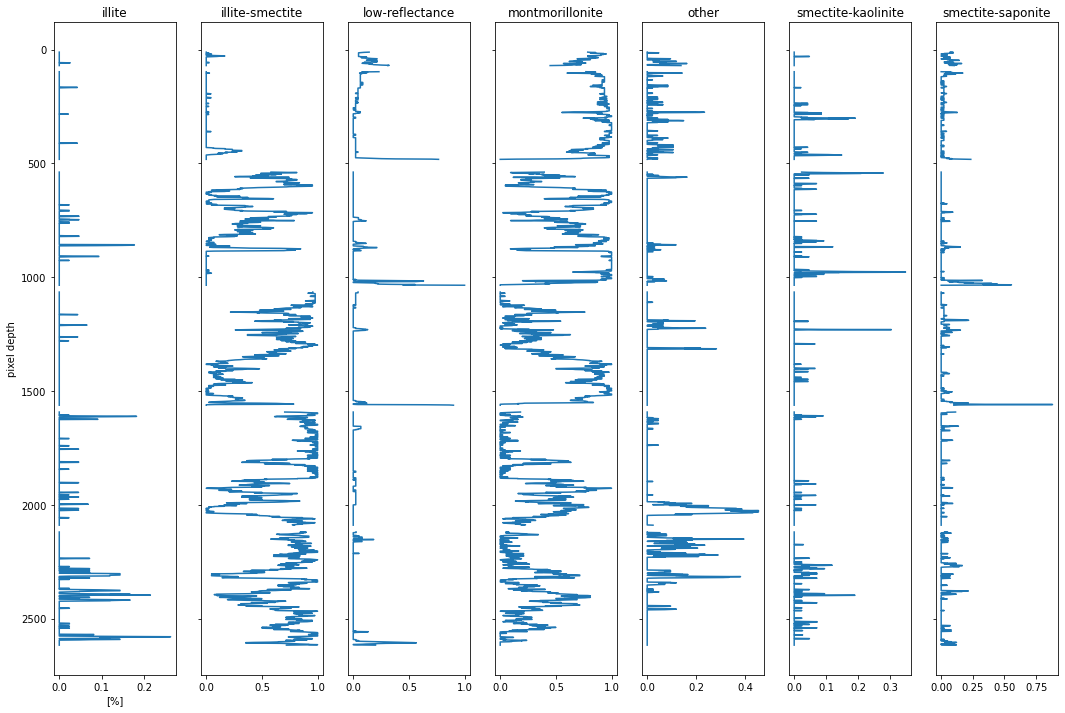

In [37]:
ax = plot_box_curves( mineral_pixel_prc_curves )
ax[0].set_xlabel( "[%]");

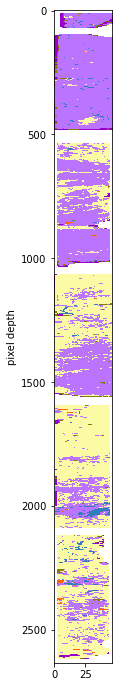

In [38]:
core_column = compartment_to_column( compartments )

plot_core_column( core_column )

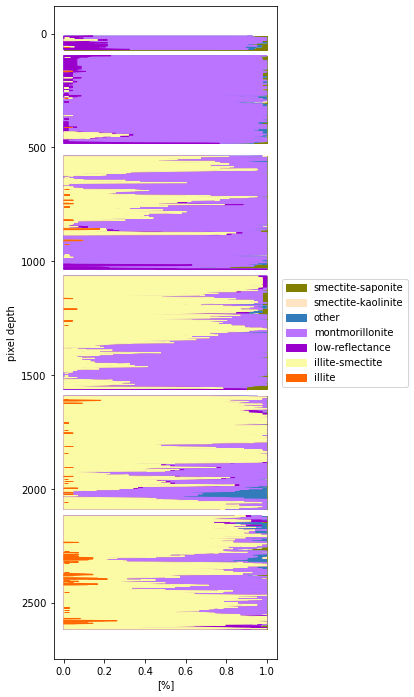

In [39]:
plot_box_composition( mineral_pixel_prc_curves, 
    mineral_keys,
    pixel_values_scaled)

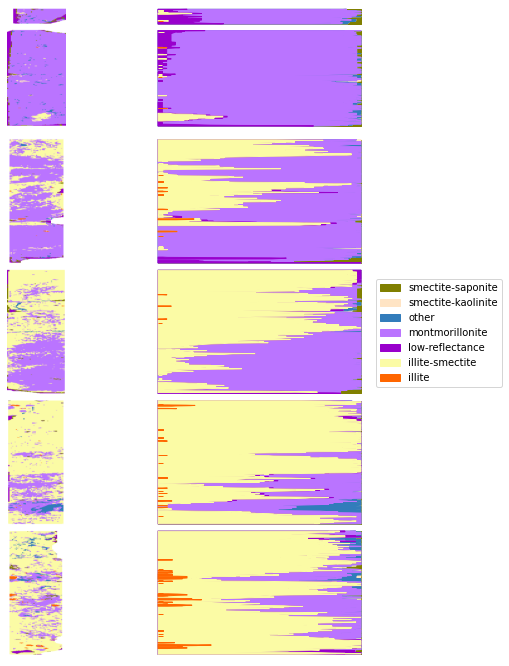

In [40]:
fig = plot_box_image_and_composition( core_column, mineral_pixel_prc_curves,  mineral_keys, pixel_values_scaled)

In [41]:
#fig.savefig("mineral-map-prc.png", dpi=300, 
#   format="png", transparent=False, 
#   bbox_inches="tight", facecolor='white')